In [1]:
import numpy as np
import pandas as pd
import glob
import sys,os

In [2]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

In [4]:
import json
import pickle
import re
from tqdm import tqdm
from pathlib import Path

### 0.API

In [5]:
!ls /nas/chenyi/datasets_nas/labelMap/standard/

id2class99_chenyi.csv


In [6]:
id_standard_df = pd.read_csv('/nas/chenyi/datasets_nas/labelMap/standard/id2class99_chenyi.csv')
id_use_df = id_standard_df[id_standard_df['use']>=0]

In [7]:
# with open('/home/chenyi/workspace/myPyModule99/dataset/labelMap/standard/haowei34k_map_stand.json', 'r') as f:
#     hw2stand = json.load(f)

In [8]:
# with open('./data/haowei34k_map_stand.json', 'w') as f:
#     json.dump(hw2stand, f)

In [7]:
def get_list2dict(k_list, v_list):
    d = {}
    for item in zip(k_list, v_list):
        d[item[0]] = item[1]
    return d

In [8]:
def write_txt(input_list):
    label_path, text = input_list[0], input_list[1]
    with open(label_path, 'a+') as f:
        f.write(text)

In [9]:
model_label_map = {
    0: 10,  # 鞋子
    1: 8,  # 包包
    2: 4,  # 上装
    3: 5,  # 裤子
    4: 6,  # 裙子
    5: 7,  # 连体装
}

In [17]:
l2_map_l1 = get_list2dict( id_use_df['label99'].values, id_use_df['label_l1'].values)

In [18]:
id2chi_l2 = get_list2dict(id_use_df['label2_chi'].values, id_use_df['label99'].values)

In [19]:
id2eng_l2 = get_list2dict(id_use_df['label99'].values, id_use_df['label2_eng'].values)

In [20]:
id2chi_l1 = get_list2dict(id_use_df['label_l1'].values, id_use_df['label1_chi'].values)

In [21]:
id2eng_l1 = get_list2dict(id_use_df['label_l1'].values, id_use_df['label1_eng'].values)

In [22]:
id2model_l1 = get_list2dict(model_label_map.values(), model_label_map.keys())

### 1.Dataset Information.

In [27]:
!tree -L 1 /home/chenyi/workspace/dataset/deepedia/info/deepedia/

/home/chenyi/workspace/dataset/deepedia/info/deepedia/
├── dpedia_bx4.csv
├── dpedia_bx_94_bakup.csv
├── dpedia_bx_94.csv
├── dpedia_clr_temp.csv
└── pedia94.csv

0 directories, 5 files


In [31]:
openfashion_pd = pd.read_csv('/home/chenyi/workspace/dataset/deepedia/info/deepedia/dpedia_bx4.csv')

In [36]:
clr_df = pd.read_csv('/home/chenyi/workspace/dataset/deepedia/info/deepedia/dpedia_clr_temp.csv')

In [413]:
# p = '/home/chenyi/workspace/myPyModule99/data_format/haowei34k_voc_bboxes_relabel.csv'
# openfashion_pd.to_csv(p, index=False)

In [32]:
openfashion_pd.head()

,img_sp,id_bbox,width,height,mode,label8,bx1,bx2,bx3,bx4,source
0,/home/chenyi/workspace/dataset/data/data_fashi...,0,721,1024,train,5,0.544383,0.875977,329.0,252.0,fashionpedia
1,/home/chenyi/workspace/dataset/data/data_fashi...,1,721,1024,train,4,0.489598,0.513184,232.0,511.0,fashionpedia
2,/home/chenyi/workspace/dataset/data/data_fashi...,2,721,1024,train,4,0.568655,0.604492,478.0,674.0,fashionpedia
3,/home/chenyi/workspace/dataset/data/data_fashi...,0,1024,1024,train,4,0.509277,0.544922,585.0,778.0,fashionpedia
4,/home/chenyi/workspace/dataset/data/data_fashi...,0,681,1024,train,7,0.505874,0.447266,171.0,426.0,fashionpedia


In [37]:
clr_df.head()

,img_sp,id_bbox,width,height,mode,label8,bx1,bx2,bx3,bx4,source
0,/home/chenyi/workspace/dataset/data/data_fashi...,2,681,1024,train,2,0.551395,0.898926,53.0,127.0,fashionpedia
1,/home/chenyi/workspace/dataset/data/data_fashi...,3,681,1024,train,2,0.477974,0.869629,43.0,39.0,fashionpedia
2,/home/chenyi/workspace/dataset/data/data_fashi...,6,682,1024,val,2,0.565249,0.833008,65.0,134.0,fashionpedia
3,/home/chenyi/workspace/dataset/data/data_fashi...,7,682,1024,val,2,0.489003,0.843750,59.0,142.0,fashionpedia
4,/home/chenyi/workspace/dataset/data/data_fashi...,3,683,1024,val,2,0.445827,0.887695,127.0,102.0,fashionpedia


In [38]:
len(openfashion_pd),len(clr_df)

(504435, 474843)

In [34]:
openfashion_pd.value_counts('source')

source
deepfashion2    364676
fashionpedia    139759
dtype: int64

In [39]:
clr_df.value_counts('source')

source
deepfashion2    348285
fashionpedia    126558
dtype: int64

In [40]:
openfashion_pd.describe()

,id_bbox,width,height,label8,bx1,bx2,bx3,bx4
count,504435.000000,504435.000000,504435.000000,504435.000000,504435.000000,504435.000000,504435.000000,5.044350e+05
mean,0.697144,649.334600,831.216987,4.382888,0.501489,0.557624,269.329071,3.420215e+02
std,0.992921,157.343311,214.463794,1.551049,0.654593,0.900215,1042.890843,2.294867e+03
min,0.000000,68.000000,71.000000,-1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,468.000000,640.000000,4.000000,0.462667,0.424316,167.000000,1.890000e+02
50%,0.000000,675.000000,832.000000,4.000000,0.498932,0.539263,250.000000,3.100000e+02
75%,1.000000,750.000000,1024.000000,5.000000,0.537393,0.693109,354.999995,4.580000e+02
max,14.000000,2134.000000,3201.000000,7.000000,286.000000,495.000000,437803.000000,1.037428e+06


In [41]:
clr_df.describe()

,id_bbox,width,height,label8,bx1,bx2,bx3,bx4
count,474843.000000,474843.000000,474843.000000,474843.000000,474843.000000,474843.000000,474843.000000,474843.000000
mean,1.284894,654.067035,836.530900,4.538100,0.499924,0.557436,271.980004,343.186514
std,2.418048,150.229591,207.899449,1.272022,0.086475,0.199043,140.061948,190.198046
min,0.000000,301.000000,301.000000,2.000000,0.021207,0.016602,24.000000,24.000000
25%,0.000000,468.000000,640.000000,4.000000,0.463281,0.425490,173.999995,197.999997
50%,0.000000,677.000000,832.000000,4.000000,0.498932,0.541793,255.000000,316.000000
75%,1.000000,750.000000,1024.000000,5.000000,0.537500,0.696289,360.000002,462.000014
max,44.000000,2134.000000,3201.000000,7.000000,0.980469,0.987305,1368.000024,1907.000056


### 2.统计数据集

In [59]:
pedia_df = clr_df[clr_df['source']=='fashionpedia'].copy(deep=True)

In [60]:
pedia_df['bx3'] = pedia_df['bx3'].values/pedia_df['width']

In [61]:
pedia_df['bx4'] = pedia_df['bx4'].values/pedia_df['height']

In [62]:
pedia_df.head(2)

,img_sp,id_bbox,width,height,mode,label8,bx1,bx2,bx3,bx4,source
0,/home/chenyi/workspace/dataset/data/data_fashi...,2,681,1024,train,2,0.551395,0.898926,0.077827,0.124023,fashionpedia
1,/home/chenyi/workspace/dataset/data/data_fashi...,3,681,1024,train,2,0.477974,0.869629,0.063142,0.038086,fashionpedia


In [76]:
df = pedia_df[~((pedia_df['bx3']<0.05) & (pedia_df['bx4']<0.05))]

In [77]:
df = df[~((df['bx3']<0.025) | (df['bx4']<0.025))]

In [78]:
len(df), len(pedia_df)

(125609, 126558)

In [79]:
df.describe()

,id_bbox,width,height,label8,bx1,bx2,bx3,bx4
count,125609.000000,125609.000000,125609.000000,125609.000000,125609.000000,125609.000000,125609.000000,125609.000000
mean,3.696097,738.864269,989.893726,3.939423,0.492614,0.651889,0.281731,0.308710
std,3.636169,135.338436,102.215579,1.756343,0.102858,0.206981,0.216884,0.233146
min,0.000000,302.000000,388.000000,2.000000,0.021207,0.016602,0.025105,0.025391
25%,1.000000,682.000000,1024.000000,2.000000,0.444767,0.480469,0.099561,0.103516
50%,3.000000,682.000000,1024.000000,4.000000,0.496582,0.635742,0.234261,0.261719
75%,6.000000,767.000000,1024.000000,5.000000,0.539531,0.864931,0.394531,0.442383
max,44.000000,1024.000000,1024.000000,7.000000,0.979492,0.986328,0.999023,0.999023


In [88]:
df.head(2)

,img_sp,id_bbox,width,height,mode,label8,bx1,bx2,bx3,bx4,source,label_model
0,/home/chenyi/workspace/dataset/data/data_fashi...,2,681,1024,train,2,0.551395,0.898926,0.077827,0.124023,fashionpedia,0
1,/home/chenyi/workspace/dataset/data/data_fashi...,3,681,1024,train,2,0.477974,0.869629,0.063142,0.038086,fashionpedia,0


In [84]:
df.value_counts('label8').sort_index()

label8
2    42261
3     7103
4    36495
5    15101
6     5032
7    19617
dtype: int64

In [87]:
df['label_model'] =  -1
df['label_model'] =  df['label8'].apply(lambda x: int(x-2))

In [89]:
df.to_csv('./data/fashionpedia6_l1.csv', index=False)

In [358]:
openfashion_pd['label8'] = -1

In [359]:
openfashion_pd['label8'] = openfashion_pd['label99'].apply(lambda x: l2_map_l1[x])

#### 二级标签

In [409]:
openfashion_pd.head(2)

,fname,label,xmin,ymin,xmax,ymax,label43,mode,width,height,label_num,label99,label8
0,20160425101358677,正装女鞋,225,584,258,669,正装女鞋,train,533,800,23,52,10
1,20160425101358677,正装女鞋,256,672,305,768,正装女鞋,train,533,800,23,52,10


In [412]:
openfashion_pd[openfashion_pd['label8']==5].value_counts('label43')

label43
休闲裤    8833
牛仔裤    6875
打底裤    1305
西装裤    1001
皮裤      522
运动裤     166
dtype: int64

In [364]:
counter = openfashion_pd.value_counts('label_num').sort_index()

In [367]:
id_list = np.array(counter.axes)[0]
numbers = counter.values
name_list = [str(x) + ':' + str(id2eng_l2[hw2stand[str(x)][0]]) for x in id_list]

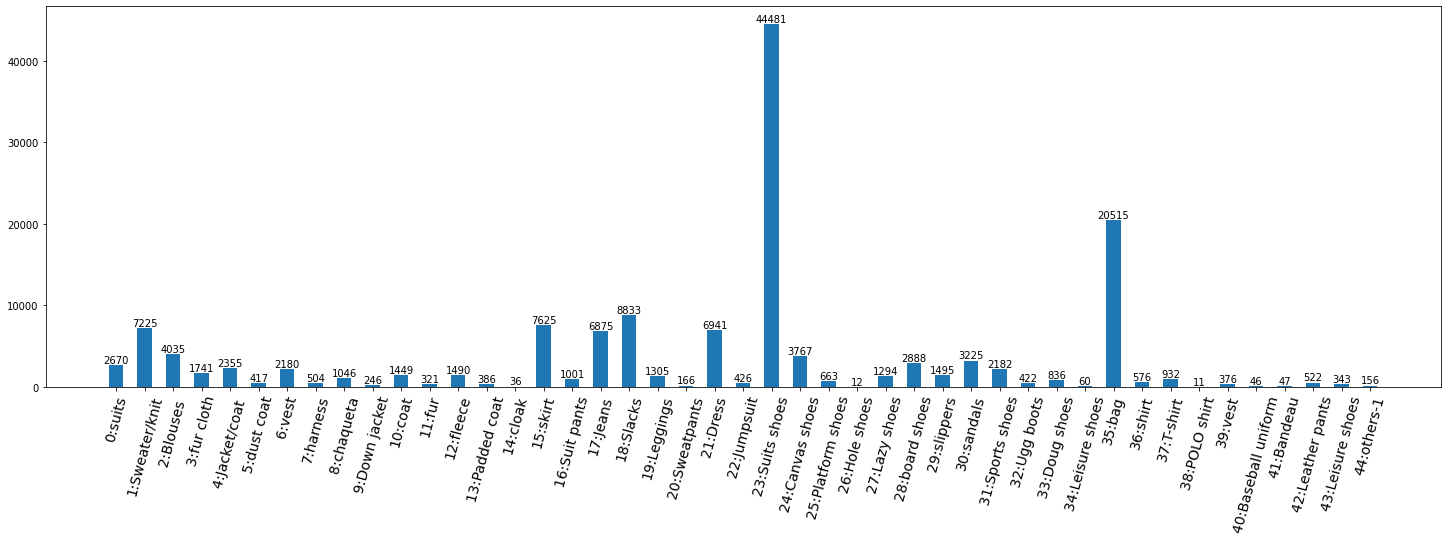

In [368]:
plt.figure(figsize=(25, 7))
plt.xticks(list(range(len(name_list))), name_list, rotation=75, fontsize=14)
plt.bar(name_list, numbers, width=0.5)  # 绘制y刻度标签
for a, b in zip(name_list, numbers):
    plt.text(a, b, b, ha='center', va='bottom')
plt.show()

#### 一级标签

In [91]:
counter = df.value_counts('label_model').sort_index()

In [ ]:
id2model_l1

In [93]:
id2eng_l1

{-1: 'other-1',
 4: 'upperbody',
 5: 'pants',
 6: 'skirt',
 7: 'wholebody',
 8: 'bag',
 10: 'shoe'}

In [94]:
id_list = np.array(counter.axes)[0]
numbers = counter.values
name_list = [str(x) + ':' + id2eng_l1[model_label_map[x]] for x in id_list]

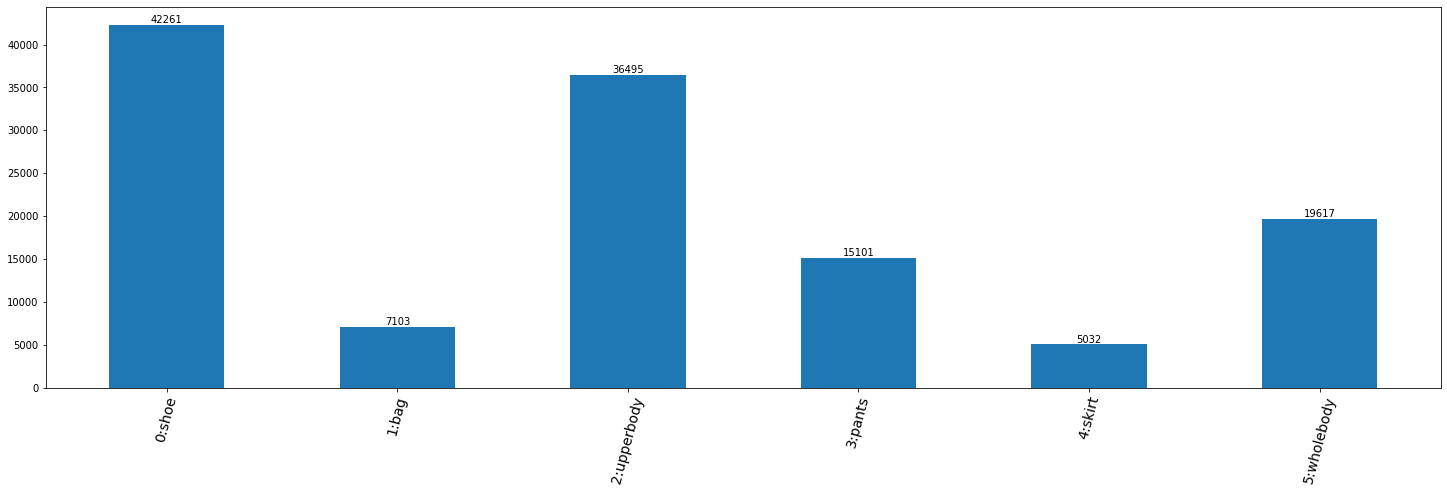

In [95]:
plt.figure(figsize=(25, 7))
plt.xticks(list(range(len(name_list))), name_list, rotation=75, fontsize=14)
plt.bar(name_list, numbers, width=0.5)  # 绘制y刻度标签
for a, b in zip(name_list, numbers):
    plt.text(a, b, b, ha='center', va='bottom')
plt.show()

In [11]:
!ls /nas/chenyi/dataset_apparel_nas/

haowei34k  haowei34k_conf7.csv	haowei34k.tar  haowei_conf07_multi  openfashion


In [12]:
hw_data_p = '/nas/chenyi/dataset_apparel_nas/haowei34k_conf7.csv'

In [13]:
hw_data_df = pd.read_csv(hw_data_p)

In [14]:
hw_data_df.head()

,id,img_path,label_path,label_1,一级分类,label_2,二级分类,x_c,y_c,w,h,confidence
0,20141215090521289,/nas/lichangjian/ok_data/20141215090521289.jpg,/nas/lichangjian/labels/20141215090521289.txt,4,上装,0,小西装,0.454839,0.320250,0.412903,0.362912,0.961302
1,20141215090521289,/nas/lichangjian/ok_data/20141215090521289.jpg,/nas/lichangjian/labels/20141215090521289.txt,5,裤子,18,休闲裤,0.440323,0.627986,0.296774,0.470990,0.953829
2,20140924211054180,/nas/lichangjian/ok_data/20140924211054180.jpg,/nas/lichangjian/labels/20140924211054180.txt,4,上装,0,小西装,0.542500,0.343897,0.198333,0.387324,0.920288
3,20140924211054180,/nas/lichangjian/ok_data/20140924211054180.jpg,/nas/lichangjian/labels/20140924211054180.txt,5,裤子,16,西装裤,0.538333,0.660798,0.156667,0.485915,0.915438
4,20141204122102902,/nas/lichangjian/ok_data/20141204122102902.jpg,/nas/lichangjian/labels/20141204122102902.txt,4,上装,4,夹克/外套,0.486250,0.341667,0.322500,0.286667,0.781202


In [15]:
counter_hw = hw_data_df['label_2'].value_counts()

In [16]:
id_list = np.array(counter_hw.axes)[0]
numbers = counter_hw.values
name_list = [str(x) + ':' + names[x][1] for x in id_list]

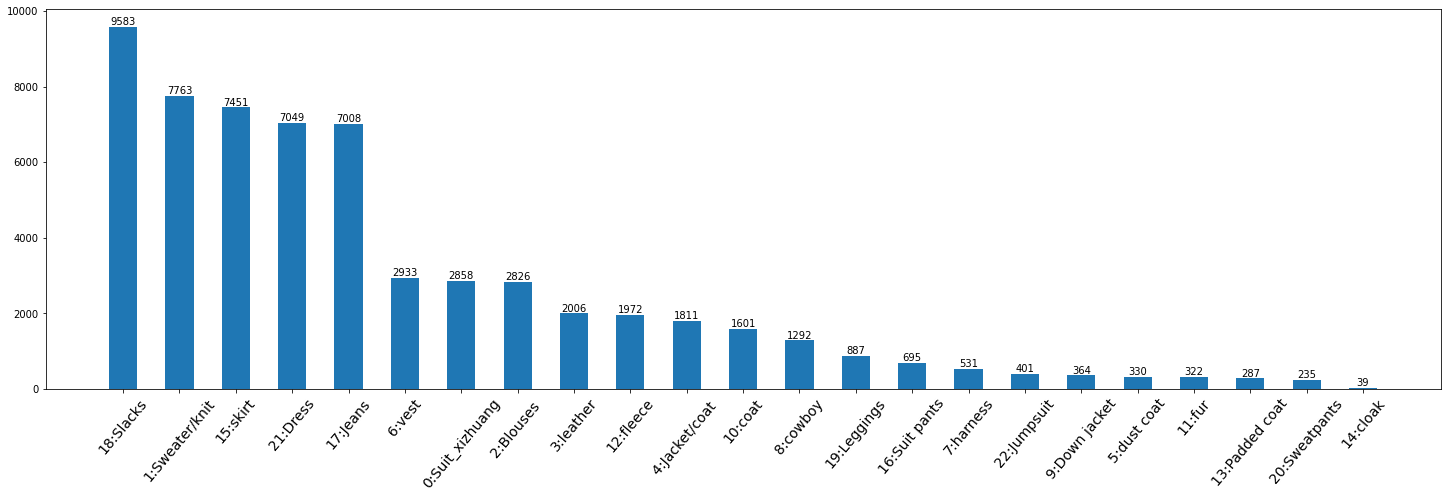

In [17]:
plt.figure(figsize=(25, 7))
plt.xticks(list(range(len(name_list))), name_list, rotation=50, fontsize=14)
plt.bar(name_list, numbers, width=0.5)  # 绘制y刻度标签
for a, b in zip(name_list, numbers):
    plt.text(a, b, b, ha='center', va='bottom')
plt.show()

### target label

In [5]:
df = pd.read_csv('./data/fashionpedia6_l1.csv')
df = df[df['label_model']>=0]

In [6]:
df.head(2)

,img_sp,id_bbox,width,height,mode,label8,bx1,bx2,bx3,bx4,source,label_model,label_tpath
0,/home/chenyi/workspace/dataset/data/data_fashi...,2,681,1024,train,2,0.551395,0.898926,0.077827,0.124023,fashionpedia,0,/home/chenyi/workspace/dataset/labels/labels6/...
1,/home/chenyi/workspace/dataset/data/data_fashi...,3,681,1024,train,2,0.477974,0.869629,0.063142,0.038086,fashionpedia,0,/home/chenyi/workspace/dataset/labels/labels6/...


#### target label path

In [17]:
root = '/home/chenyi/workspace/dataset/labels/labels6/fashionpedia/labels/'

In [20]:
df['label_tpath'] = df.apply(lambda row: Path('{0}{1}/{2}.txt'.format(root, row['mode'], Path(row['img_sp']).stem)), axis=1)

In [107]:
df.head(2).values

array([['/home/chenyi/workspace/dataset/data/data_fashionpedia/train/0002ec21ddb8477e98b2cbb87ea2e269.jpg',
        2, 681, 1024, 'train', 2, 0.5513950073421439, 0.89892578125,
        0.0778267254038179, 0.1240234375, 'fashionpedia', 0,
        PosixPath('/home/chenyi/workspace/dataset/labels/labels6/fashionpedia/labels/train/0002ec21ddb8477e98b2cbb87ea2e269.txt'),
        '0002ec21ddb8477e98b2cbb87ea2e269'],
       ['/home/chenyi/workspace/dataset/data/data_fashionpedia/train/0002ec21ddb8477e98b2cbb87ea2e269.jpg',
        3, 681, 1024, 'train', 2, 0.4779735682819383, 0.86962890625,
        0.0631424375917768, 0.0380859375, 'fashionpedia', 0,
        PosixPath('/home/chenyi/workspace/dataset/labels/labels6/fashionpedia/labels/train/0002ec21ddb8477e98b2cbb87ea2e269.txt'),
        '0002ec21ddb8477e98b2cbb87ea2e269']], dtype=object)

In [24]:
!ls /home/chenyi/workspace/dataset/labels/labels6/

fashionpedia  haowei34k


In [36]:
# df.to_csv('./data/fashionpedia6_l1.csv', index=    False)

#### 生成txt

In [108]:
sys.path.append('../../')

In [109]:
from utils.bbox.conversation import bbox_coco2voc,bbox_voc2yolo,bbox_yolo2voc

In [110]:
bboxes_list = []
for ind,row in tqdm(df.iterrows()):
    bbox7 = row.loc[['label_model', 'bx1', 'bx2', 'bx3', 'bx4', 'width', 'height']].values.tolist()
    bbox5 = bbox7[:6]
    # bbox5[1:] = bbox_voc2yolo(bbox5[1:], bbox7[5], bbox7[6])
    bbox5_str = '{0:.0f} {1:.6f} {2:.6f} {3:.6f} {4:.6f}\n'.format(*bbox5)
    bboxes_list.append(bbox5_str)
    # break

125609it [00:27, 4621.97it/s]


In [111]:
def write_txt(label_path, text):
    # label_path, text = input_list[0], input_list[1]
    label_path = Path(label_path)
    p_parent = label_path.parent
    if not p_parent.is_dir():
        p_parent.mkdir(parents=True)
    if not p_parent.is_file():
        with open(label_path, 'a+') as f:
            f.write(text)

In [29]:
for label_path, text in tqdm(zip(df['label_tpath'].values, bboxes_list)):
    write_txt(label_path, text)
    # breakparents=

125609it [00:03, 32867.00it/s]


In [114]:
df['label_tpath'].values[:5]

array([PosixPath('/home/chenyi/workspace/dataset/labels/labels6/fashionpedia/labels/train/0002ec21ddb8477e98b2cbb87ea2e269.txt'),
       PosixPath('/home/chenyi/workspace/dataset/labels/labels6/fashionpedia/labels/train/0002ec21ddb8477e98b2cbb87ea2e269.txt'),
       PosixPath('/home/chenyi/workspace/dataset/labels/labels6/fashionpedia/labels/val/00048c3a2fb9c29340473c4cfc06424a.txt'),
       PosixPath('/home/chenyi/workspace/dataset/labels/labels6/fashionpedia/labels/val/00048c3a2fb9c29340473c4cfc06424a.txt'),
       PosixPath('/home/chenyi/workspace/dataset/labels/labels6/fashionpedia/labels/val/0006ea84499fd9a06fefbdf47a5eb4c0.txt')],
      dtype=object)

In [30]:
!cat $label_path

5 0.565104 0.557617 0.458333 0.656250


#### 生成软连接的path

In [61]:
slink_df.head(2)

,stem,label_sp,label_tp,img_tp,img_sp
0,0002ec21ddb8477e98b2cbb87ea2e269,/home/chenyi/workspace/dataset/labels/labels6/...,/home/chenyi/workspace/yolov5/datasets/dadet10...,/home/chenyi/workspace/yolov5/datasets/dadet10...,/home/chenyi/workspace/dataset/data/data_fashi...
1,00048c3a2fb9c29340473c4cfc06424a,/home/chenyi/workspace/dataset/labels/labels6/...,/home/chenyi/workspace/yolov5/datasets/dadet10...,/home/chenyi/workspace/yolov5/datasets/dadet10...,/home/chenyi/workspace/dataset/data/data_fashi...


In [60]:
slink_df.head(2).values

array([['0002ec21ddb8477e98b2cbb87ea2e269',
        PosixPath('/home/chenyi/workspace/dataset/labels/labels6/fashionpedia/labels/train/0002ec21ddb8477e98b2cbb87ea2e269.txt'),
        PosixPath('/home/chenyi/workspace/yolov5/datasets/dadet100kv2/labels/train/0002ec21ddb8477e98b2cbb87ea2e269.txt'),
        PosixPath('/home/chenyi/workspace/yolov5/datasets/dadet100kv2/images/train/0002ec21ddb8477e98b2cbb87ea2e269.jpg'),
        '/home/chenyi/workspace/dataset/data/data_fashionpedia/train/0002ec21ddb8477e98b2cbb87ea2e269.jpg'],
       ['00048c3a2fb9c29340473c4cfc06424a',
        PosixPath('/home/chenyi/workspace/dataset/labels/labels6/fashionpedia/labels/val/00048c3a2fb9c29340473c4cfc06424a.txt'),
        PosixPath('/home/chenyi/workspace/yolov5/datasets/dadet100kv2/labels/val/00048c3a2fb9c29340473c4cfc06424a.txt'),
        PosixPath('/home/chenyi/workspace/yolov5/datasets/dadet100kv2/images/val/00048c3a2fb9c29340473c4cfc06424a.jpg'),
        '/home/chenyi/workspace/dataset/data/data_fashi

In [48]:
df['stem'] = df['img_sp'].apply(lambda x: Path(x).stem)

In [49]:
drop_df = df.drop_duplicates('label_tpath')

In [50]:
slink_df = pd.DataFrame()
slink_df['stem'] = drop_df['stem'].values
slink_df['label_sp'] = drop_df['label_tpath'].values

In [52]:
root = Path('/home/chenyi/workspace/yolov5/datasets/dadet100kv2/')
troot = Path('/home/chenyi/workspace/dataset/data/data_fashionpedia/')

In [53]:
slink_df['label_tp'] = slink_df['label_sp'].apply(lambda x: root /'labels' /x.parts[-2]/x.parts[-1])

In [54]:
slink_df['img_tp'] = slink_df['label_sp'].apply(lambda x: root /'images' /x.parts[-2]/x.parts[-1])
slink_df['img_tp'] = slink_df['img_tp'].apply(lambda x: x.with_suffix('.jpg'))

In [58]:
# slink_df['image_spath'] = slink_df['image_tpath'].apply(lambda x: troot /'images' /x.parts[-2]/x.parts[-1])
slink_df['img_sp'] = drop_df['img_sp'].values

In [59]:
# slink_df.to_csv('./data/deepedia6_slink.csv', index=False)

#### 生成sym link

In [82]:
root = f'/{folder_name}'
!tree  -d -L 1 /home/chenyi/workspace/yolov5/datasets

/home/chenyi/workspace/yolov5/datasets
├── coco128
├── dadet100kv2
├── deepedia
├── deepedia6_shbg
├── deepedia_catg6
├── deepedia_catg8
├── deepedia_catg9
├── haowei_bag_shoe
├── hwpedia80k
├── tuneGallery10k
├── tuneGallery4k
├── tuneQuery10k
└── validation_all

13 directories


##### 直接读取csv

In [62]:
slink_df = pd.read_csv('./data/fashionpedia6_slink.csv')

In [121]:
slink_df.head(2).values

array([['0002ec21ddb8477e98b2cbb87ea2e269',
        '/home/chenyi/workspace/dataset/hw_pedia_true/labels6_true/train/0002ec21ddb8477e98b2cbb87ea2e269.txt',
        '/home/chenyi/workspace/yolov5/datasets/dadet100kv2/labels/train/0002ec21ddb8477e98b2cbb87ea2e269.txt',
        '/home/chenyi/workspace/yolov5/datasets/dadet100kv2/images/train/0002ec21ddb8477e98b2cbb87ea2e269.jpg',
        '/home/chenyi/workspace/dataset/data/data_fashionpedia/train/0002ec21ddb8477e98b2cbb87ea2e269.jpg'],
       ['00048c3a2fb9c29340473c4cfc06424a',
        '/home/chenyi/workspace/dataset/hw_pedia_true/labels6_true/val/00048c3a2fb9c29340473c4cfc06424a.txt',
        '/home/chenyi/workspace/yolov5/datasets/dadet100kv2/labels/val/00048c3a2fb9c29340473c4cfc06424a.txt',
        '/home/chenyi/workspace/yolov5/datasets/dadet100kv2/images/val/00048c3a2fb9c29340473c4cfc06424a.jpg',
        '/home/chenyi/workspace/dataset/data/data_fashionpedia/train/00048c3a2fb9c29340473c4cfc06424a.jpg']],
      dtype=object)

In [70]:
slink_df.head(2).values

array([['0002ec21ddb8477e98b2cbb87ea2e269',
        '/home/chenyi/workspace/dataset/hw_pedia_true/labels6_true/train/0002ec21ddb8477e98b2cbb87ea2e269.txt',
        '/home/chenyi/workspace/yolov5/datasets/hwpedia80k/labels/train/0002ec21ddb8477e98b2cbb87ea2e269.txt',
        '/home/chenyi/workspace/yolov5/datasets/hwpedia80k/images/train/0002ec21ddb8477e98b2cbb87ea2e269.jpg',
        '/home/chenyi/workspace/dataset/data/data_fashionpedia/train/0002ec21ddb8477e98b2cbb87ea2e269.jpg'],
       ['00048c3a2fb9c29340473c4cfc06424a',
        '/home/chenyi/workspace/dataset/hw_pedia_true/labels6_true/val/00048c3a2fb9c29340473c4cfc06424a.txt',
        '/home/chenyi/workspace/yolov5/datasets/hwpedia80k/labels/val/00048c3a2fb9c29340473c4cfc06424a.txt',
        '/home/chenyi/workspace/yolov5/datasets/hwpedia80k/images/val/00048c3a2fb9c29340473c4cfc06424a.jpg',
        '/home/chenyi/workspace/dataset/data/data_fashionpedia/train/00048c3a2fb9c29340473c4cfc06424a.jpg']],
      dtype=object)

In [83]:
origin_folder = 'hwpedia80k'
folder_name = 'dadet100kv2'

In [84]:
slink_df['img_tp'] = slink_df['img_tp'].apply(lambda x:x.replace(f'/datasets/{origin_folder}/images/', f'/datasets/{folder_name}/images/'))
slink_df['label_tp'] = slink_df['label_tp'].apply(lambda x:x.replace(f'/datasets/{origin_folder}/labels/', f'/datasets/{folder_name}/labels/'))

In [85]:
# folder_name = 'hwpedia80k'
root = f'/home/chenyi/workspace/yolov5/datasets/{folder_name}'
!tree  -d -L 2 $root

/home/chenyi/workspace/yolov5/datasets/dadet100kv2
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories


In [86]:
len(slink_df), len(glob.glob(f'{root}/images/*/*.jpg')), len(glob.glob(f'{root}/labels/*/*.txt'))

(45529, 97994, 97994)

In [87]:
slink_df.head(2)

,fname,label_sp,label_tp,img_tp,img_sp
0,0002ec21ddb8477e98b2cbb87ea2e269,/home/chenyi/workspace/dataset/hw_pedia_true/l...,/home/chenyi/workspace/yolov5/datasets/dadet10...,/home/chenyi/workspace/yolov5/datasets/dadet10...,/home/chenyi/workspace/dataset/data/data_fashi...
1,00048c3a2fb9c29340473c4cfc06424a,/home/chenyi/workspace/dataset/hw_pedia_true/l...,/home/chenyi/workspace/yolov5/datasets/dadet10...,/home/chenyi/workspace/yolov5/datasets/dadet10...,/home/chenyi/workspace/dataset/data/data_fashi...


In [88]:
%%time
for p in slink_df['label_tp'].values:
    if Path(p).is_symlink():
        Path(p).unlink()
_ = slink_df.apply(lambda row: Path.symlink_to(Path(row['label_tp']), Path(row['label_sp'])), axis=1)

CPU times: user 1.51 s, sys: 871 ms, total: 2.38 s
Wall time: 2.46 s


In [89]:
%%time
for p in slink_df['img_tp'].values:
    if Path(p).is_symlink():
        Path(p).unlink()
_ = slink_df.apply(lambda row: Path.symlink_to(Path(row['img_tp']), Path(row['img_sp'])), axis=1)

CPU times: user 1.41 s, sys: 1.08 s, total: 2.49 s
Wall time: 2.63 s


In [90]:
len(slink_df), len(glob.glob(f'{root}/images/*/*.jpg')), len(glob.glob(f'{root}/labels/*/*.txt'))

(45529, 97994, 97994)

In [91]:
p = str(slink_df['label_tp'][0])
!cat $p

0 0.551395 0.898926 0.077827 0.124023
0 0.477974 0.869629 0.063142 0.038086
5 0.505874 0.447266 0.251101 0.416016


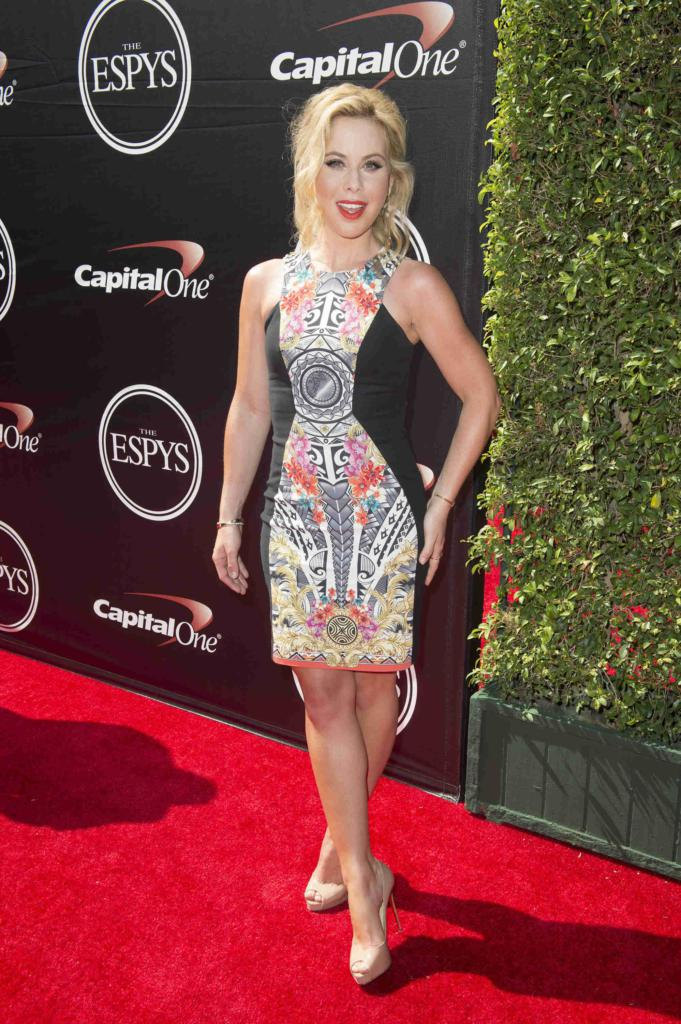

In [92]:
Image.open(slink_df['img_tp'][0])

In [93]:
def check_syslink(root, mode='images'):
    subfix = '.txt' if mode=='labels' else '.jpg'
    flag_list = [os.path.isfile(os.readlink(p)) for p in glob.glob(f'{root}/{mode}/*/*{subfix}')]
    txt_df = pd.DataFrame()
    txt_df['flag'] = flag_list
    return txt_df.value_counts('flag')

In [94]:
%%time
check_syslink(root, mode='images')

CPU times: user 197 ms, sys: 240 ms, total: 438 ms
Wall time: 442 ms


flag
True    97994
dtype: int64

In [95]:
%%time
check_syslink(root, mode='labels')

CPU times: user 211 ms, sys: 255 ms, total: 466 ms
Wall time: 556 ms


flag
True    97994
dtype: int64

In [96]:
p = '/home/chenyi/workspace/yolov5/datasets/dadet100kv2/images/val/20170819084338171.jpg'

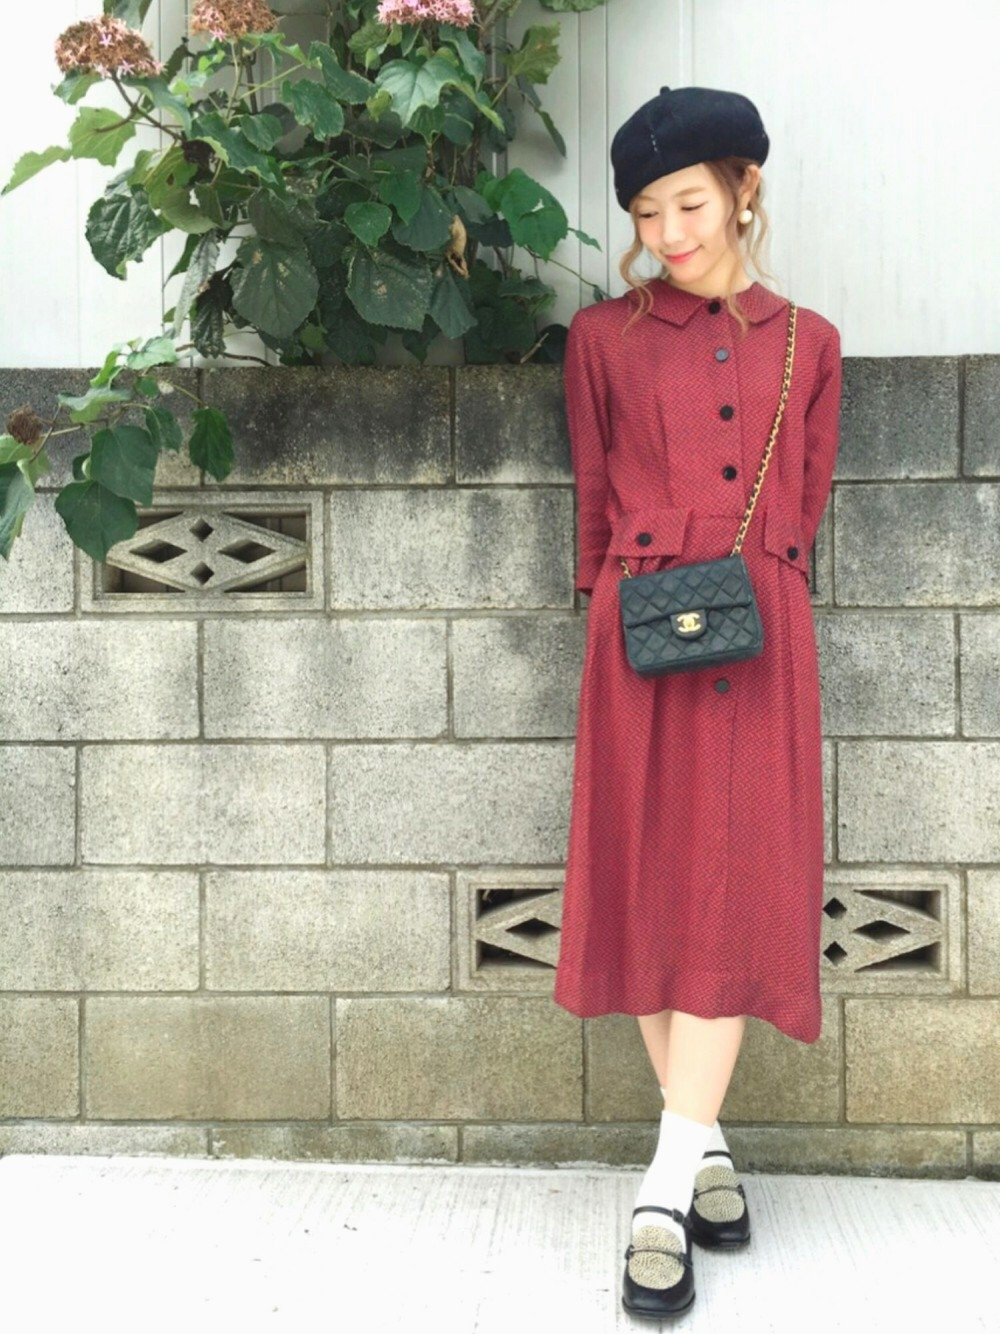

In [98]:
Image.open(p)

In [99]:
p = '/home/chenyi/workspace/yolov5/datasets/dadet100kv2/labels/val/20170819084338171.txt'
!cat $p

5 0.696500 0.492879 0.301000 0.582459
1 0.703000 0.485007 0.222000 0.203898
nan 0.685000 0.109445 0.276000 0.086957
0 0.656500 0.937406 0.127000 0.123688
0 0.740000 0.896552 0.170000 0.145427
